(4846, 50, 5)
(539, 50, 5)


C:\Users\siwoo\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
137/137 [==============================] - 46s 64ms/step - loss: 0.0545 - val_loss: 3.1406e-04
Epoch 2/50
137/137 [==============================] - 4s 30ms/step - loss: 7.3316e-04 - val_loss: 1.6550e-04
Epoch 3/50
137/137 [==============================] - 4s 27ms/step - loss: 5.5610e-04 - val_loss: 1.5777e-04
Epoch 4/50
137/137 [==============================] - 4s 28ms/step - loss: 5.3120e-04 - val_loss: 1.6186e-04
Epoch 5/50
137/137 [==============================] - 4s 27ms/step - loss: 4.6403e-04 - val_loss: 2.3119e-04
Epoch 6/50
137/137 [==============================] - 4s 29ms/step - loss: 4.9868e-04 - val_loss: 1.2651e-04
Epoch 7/50
137/137 [==============================] - 4s 29ms/step - loss: 4.3716e-04 - val_loss: 1.2894e-04
Epoch 8/50
137/137 [==============================] - 4s 33ms/step - loss: 3.6447e-04 - val_loss: 1.1994e-04
Epoch 9/50
137/137 [==============================] - 4s 32ms/step - loss: 3.7614e-04 - val_loss: 1.2186e-04
Epoch 10/50
137/137 [=

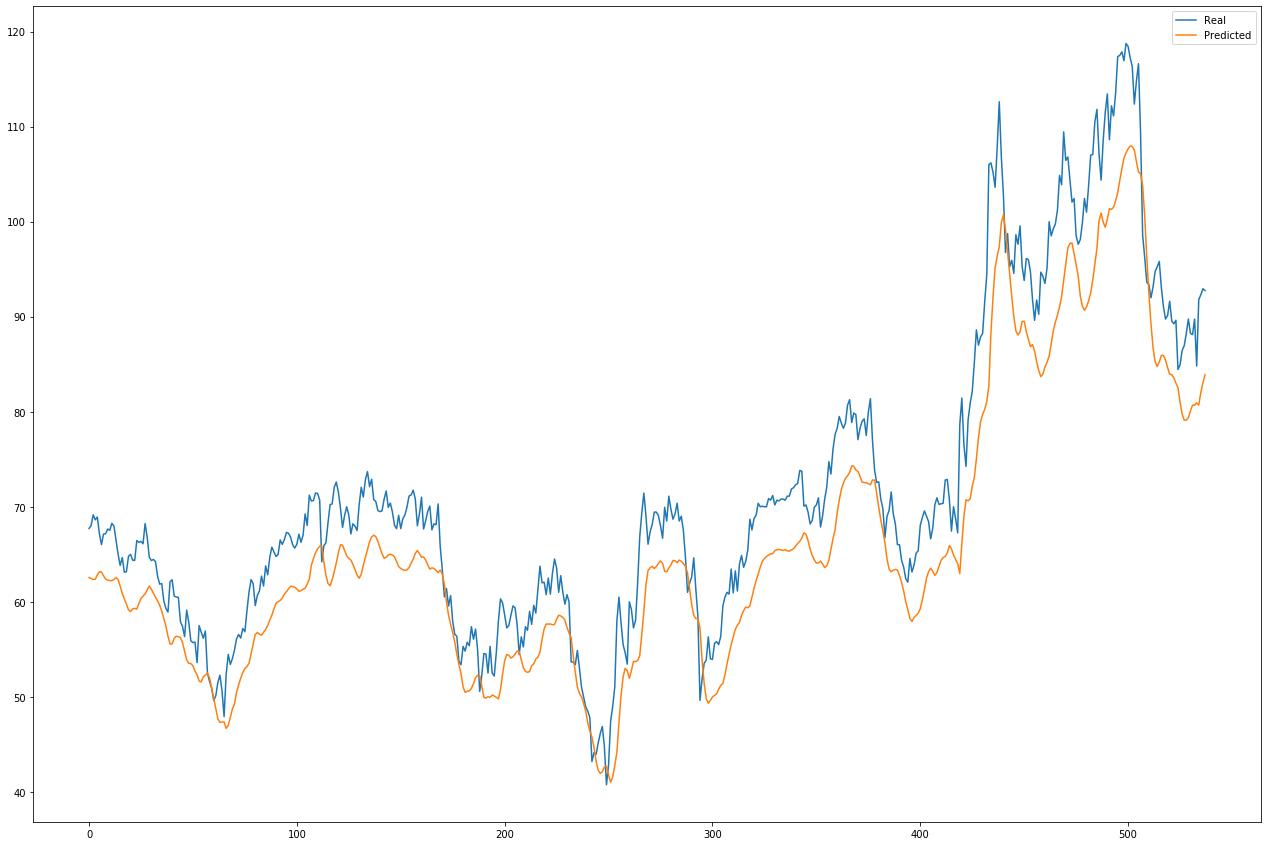

In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
np.random.seed(4)
import tensorflow
tensorflow.random.set_seed(4)
from util import csv_to_dataset, history_points


# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = csv_to_dataset('MSFT_daily.csv')

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

print(ohlcv_train.shape)
print(ohlcv_test.shape)


# model architecture

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print("scaled mean squared error: ",scaled_mse)

import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

from datetime import datetime
model.save(f'basic_model.h5')
